In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train_data = pd.read_csv("train/train_metadata.csv")
train_data_additional = pd.read_csv("train/Features/additional_features.csv")
train_data_color_histogram = pd.read_csv("train/Features/color_histogram.csv")
train_data_hog_pca = pd.read_csv("train/Features/hog_pca.csv")

train_features = pd.merge(train_data_color_histogram, train_data_hog_pca, on='image_path')
train_features = pd.merge(train_features, train_data_additional, on='image_path')
train_features = pd.merge(train_features, train_data[['image_path', 'ClassId']], on='image_path')

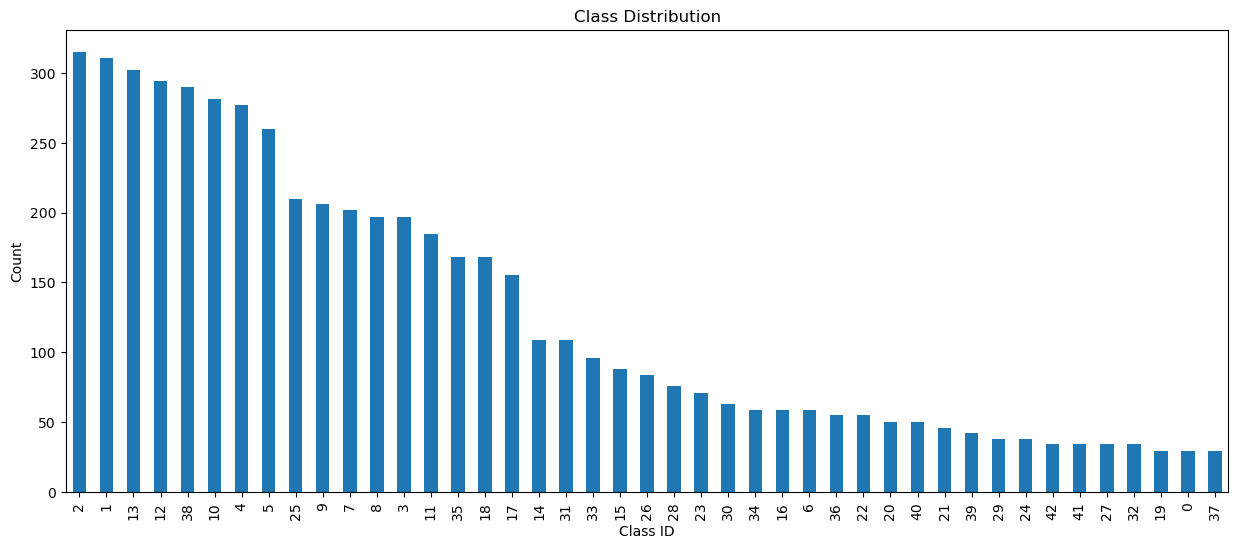

In [131]:
# checking for class imbalance

class_counts = train_features['ClassId'].value_counts()
# print(class_counts)

plt.figure(figsize=(15, 6))
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class ID')
plt.ylabel('Count')
plt.show()

# Image Processsing

In [132]:
# image enhancement and normalization
import cv2
import os
from tqdm import tqdm

# loads and resizes image to 1000 x 1000 pixels
def load_image(path, data_type):
    path = os.path.join(data_type, path)  
    img = cv2.imread(path)
    img = cv2.resize(img, (1000, 1000))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# # Reading the input image
# def erode_dilate(img):
    
#     # Taking a matrix of size 5 as the kernel
#     kernel = np.ones((5, 5), np.uint8)

#     # The first parameter is the original image,
#     # kernel is the matrix with which image is
#     # convolved and third parameter is the number
#     # of iterations, which will determine how much
#     # you want to erode/dilate a given image.
#     img_erosion = cv2.erode(img, kernel, iterations=1)
#     img_dilation = cv2.dilate(img, kernel, iterations=1)

#     cv2.imshow('Input', img)
#     cv2.imshow('Erosion', img_erosion)
#     cv2.imshow('Dilation', img_dilation)

# erode_dilate(load_image('img_000001.jpg'))


# not that necessary, images already very small n blurry, after scaling up theres barely any noise
# def de_noise(img):
#     dst = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 15)
#     return dst

# https://www.geeksforgeeks.org/clahe-histogram-eqalization-opencv/
def enhance_image(img):
    # converting to LAB color space so we can up teh brightness without affecting colors
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    
    # applying CLAHE to only the brightness channel 
    clahe = cv2.createCLAHE(clipLimit=5)
    lab[:,:,0] = clahe.apply(lab[:,:,0])
    
    enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB) 

    return enhanced

# modified circle detection function from 
# https://www.geeksforgeeks.org/circle-detection-using-opencv-python/
def detect_circle(img):
    # Convert to grayscale.
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Blur using 3 * 3 kernel.
    gray_blurred = cv2.blur(gray, (3, 3))

    # Apply Hough transform on the blurred image
    detected_circles = cv2.HoughCircles(gray_blurred, 
                   cv2.HOUGH_GRADIENT, 1, 20, param1 = 50,
               param2 = 30, minRadius = 100, maxRadius = 500)

    return 1 if detected_circles is not None else 0


# # Demonstrate enhancement on a few images
# # written by claude
# sample_images = train_features['image_path'].values[15:20]
# plt.figure(figsize=(20, 10))
# for i, img_path in enumerate(sample_images):
#     img = load_image(img_path)
#     if img is not None:
#         enhanced = enhance_image(img)
#         circle = detect_circle(enhanced)
#         print(circle)
        
#         plt.subplot(3, 5, i+1)
#         plt.imshow(img)
#         plt.title('Original')
#         plt.axis('off')
        
#         plt.subplot(3, 5, i+6)
#         plt.imshow(enhanced)
#         plt.title('Enhanced')
#         plt.axis('off')

# plt.tight_layout()
# # plt.show()


# extracts color features from an image
def extract_color_features(img):
    features = []

    # RGB stats
    for i, channel in enumerate(['R', 'G', 'B']):
        channel_data = img[:,:,i].flatten()
        mean = np.mean(channel_data)
        std = np.std(channel_data)
        skew = (3 * (mean - np.median(channel_data))) / std if std > 0 else 0

        # 10th and 90th percentiles for capturing color distribution without outlier influence
        p10 = np.percentile(channel_data, 10)
        p90 = np.percentile(channel_data, 90)
        
        features.extend([std, skew, p10, p90])
    
    # HSV stats 
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    for i, channel in enumerate(['H', 'S', 'V']):
        channel_data = hsv[:,:,i].flatten()
        mean = np.mean(channel_data)
        std = np.std(channel_data)
        features.extend([mean, std])
    
    return features

def process_all_images(metadata_df, data_type):
    all_features = []
    feature_names = ['image_path']
    
    rgb_features = ['std_r', 'skew_r', 'p10_r', 'p90_r', 
                   'std_g', 'skew_g', 'p10_g', 'p90_g',
                   'std_b', 'skew_b', 'p10_b', 'p90_b']
    
    hsv_features = ['mean_h', 'std_h', 'mean_s', 'std_s', 'mean_v', 'std_v']
    
    feature_names.extend(rgb_features)
    feature_names.extend(hsv_features)
    
    for idx, row in tqdm(metadata_df.iterrows(), total=len(metadata_df), desc="Processing images"):
        image_path = row['image_path']
        img = load_image(image_path, data_type)
        enhanced = enhance_image(img)
        color_features = extract_color_features(enhanced)
        features = [image_path] + color_features
        all_features.append(features)
            
    features_df = pd.DataFrame(all_features, columns=feature_names)

    features_df.to_csv('aaaaa.csv', index=False)
    return features_df 

# Model Testing

In [134]:
from sklearn.model_selection import train_test_split
processed_image_features = process_all_images(train_data, 'train')
train_features = pd.merge(processed_image_features, train_features, on='image_path')

# from sklearn.preprocessing import StandardScaler
# feature_columns = [col for col in train_features.columns if col not in ['image_path', 'ClassId']]
# train_features[feature_columns] = StandardScaler().fit_transform(train_features[feature_columns])

X = train_features.drop(['image_path', 'ClassId'], axis=1)
y = train_features['ClassId']
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=30027, stratify=y)

Processing images: 100%|██████████| 5488/5488 [02:40<00:00, 34.13it/s]


In [136]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
dt = DecisionTreeClassifier(max_depth=10000)
import numpy as np

for test_size in [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    print('Running experiments with test set size: {}'.format(test_size))
    accuracies = []
    
    for i in range(50):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=i)
        
        dt.fit(X_train, y_train)
        dt_acc = accuracy_score(dt.predict(X_test), y_test)
        accuracies.append(dt_acc)
    
    avg_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    print('Average Test Accuracy over 100 runs: {:.4f} ± {:.4f}'.format(avg_accuracy, std_accuracy))
    print('Min: {:.4f}, Max: {:.4f}'.format(np.min(accuracies), np.max(accuracies)))
    print()

Running experiments with test set size: 0.01
Average Test Accuracy over 100 runs: 0.5789 ± 0.0610
Min: 0.4545, Max: 0.7273

Running experiments with test set size: 0.1


In [126]:
# getting the top 20 features most correlated with class
correlations = []
for col in train_features.columns:
    if col not in ['image_path', 'ClassId']:
        corr = train_features[col].corr(train_features['ClassId'])
        correlations.append((col, corr))

top_correlations = sorted(correlations, key=lambda x: abs(x[1]), reverse=True)[:20]
for num, (feature, corr) in enumerate(top_correlations):
    print(f"{str(num + 1) + '.':<3} {feature:<11}: {corr:7.4f}")

1.  hog_pca_0  :  0.3682
2.  hog_pca_7  :  0.3309
3.  hog_pca_3  : -0.3275
4.  p10_b_x    :  0.3217
5.  p10_b_y    :  0.3217
6.  hog_pca_8  :  0.3137
7.  hog_pca_2  : -0.2958
8.  mean_s_x   :  0.2721
9.  mean_s_y   :  0.2721
10. p10_r_x    : -0.2707
11. p10_r_y    : -0.2707
12. std_s_x    :  0.2191
13. std_s_y    :  0.2191
14. std_h_x    : -0.1974
15. std_h_y    : -0.1974
16. p10_g_x    :  0.1705
17. p10_g_y    :  0.1705
18. hog_pca_12 : -0.1667
19. mean_b     :  0.1468
20. std_r_x    :  0.1275


In [127]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import warnings

warnings.simplefilter(action='ignore', category=UserWarning)

# Define the parameter grid to search over
# param_grid = {'max_iter': [100, 500, 1000, 5000, 10000]}

# param_grid = {'max_iter': [10000, 15000, 20000]}
# param_grid = {'max_iter': [7500, 10000, 12500]}
# param_grid = {'max_iter': [9000, 10000, 11000]}
param_grid = {'max_iter': [10500, 11000, 11500]}

# param_grid = {'max_iter': [5000, 7500, 10000]}
# param_grid = {'max_iter': [5000, 6250, 7500]}
# param_grid = {'max_iter': [6000, 6250, 6500]}
# param_grid = {'max_iter': [6200, 6250, 6300]}

# Create a logistic regression classifier
lgr = LogisticRegression()

print("This will take a while. Be Patient!")

# Use GridSearchCV to find the best max_iter value
grid_search = GridSearchCV(lgr, param_grid, cv=3)
grid_search.fit(X_train, y_train)

# Print the best parameters and accuracy score
print("Best max_iter value:", grid_search.best_params_['max_iter'])
print("Accuracy:", grid_search.score(X_eval, y_eval))

This will take a while. Be Patient!


KeyboardInterrupt: 

In [92]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#try to change C to 1000 or 0.001
C = 1.0  # SVM regularization parameter

models = [GaussianNB(),
        #   MultinomialNB(),
          DecisionTreeClassifier(max_depth=1), #Cross Validation Acc 0.11024124818847805
          KNeighborsClassifier(n_neighbors=1),
          KNeighborsClassifier(n_neighbors=5),
          DecisionTreeClassifier(max_depth=None),
          svm.LinearSVC(C=C),
          svm.SVC(kernel='rbf', gamma=0.7, C=C), #Cross Validation Acc 0.15761105128102856
          svm.SVC(kernel='poly', degree=3, C=C), #Cross Validation Acc 0.13228730405647962
          LogisticRegression(max_iter=11000),
          RandomForestClassifier(n_estimators=100, random_state=30027)          ]

titles = ['Naives Bayes',
        #   'Multinomial Naives Bayes',
          '1-R',
          '1-Nearest Neighbour',
          '5-Nearest Neighbour',
          'Decision Tree',
          'LinearSVC',
          'SVM with a cubic kernel',
          'SVM with an RBF kernel',
          'Logistic Regression',
          'Random Forest']

# title_training_acc = {}
# for title, model in zip(titles, models):
#     model.fit(X_train, y_train)
#     title_training_acc[title] = model.score(X_eval, y_eval)

title_crossvalidation_acc = {}
for title, model in zip(titles, models):
    title_crossvalidation_acc[title] = np.mean(cross_val_score(model, X, y, cv=10))

# for title in titles:
#     print(title, ': Training Acc', title_training_acc[title], '; Cross Validation Acc', title_crossvalidation_acc[title])

for title in titles:
    print(title, '; Cross Validation Acc', title_crossvalidation_acc[title])

/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/

Naives Bayes ; Cross Validation Acc 0.23123362982463141
1-R ; Cross Validation Acc 0.11024124818847805
1-Nearest Neighbour ; Cross Validation Acc 0.6047754377567707
5-Nearest Neighbour ; Cross Validation Acc 0.42930211532580803
Decision Tree ; Cross Validation Acc 0.5599510722880353
LinearSVC ; Cross Validation Acc 0.41266735803650967
SVM with a cubic kernel ; Cross Validation Acc 0.057398322098573394
SVM with an RBF kernel ; Cross Validation Acc 0.16381310411763925
Logistic Regression ; Cross Validation Acc 0.8163296238682143
Random Forest ; Cross Validation Acc 0.8187022190312844


In [96]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

np.random.seed(30027)

class StackingClassifier():

    def __init__(self, classifiers, metaclassifier):
        self.classifiers = classifiers
        self.metaclassifier = metaclassifier

    def fit(self, X, y):
        for clf in self.classifiers:
            clf.fit(X, y)
        X_meta = self._predict_base(X) #X_meta is the output (y_hat) of the base classifiers
        self.metaclassifier.fit(X_meta, y) #output of the base classifiers is the input for the meta classifier
    
    def _predict_base(self, X):
        yhats = []
        for clf in self.classifiers:
            yhat = clf.predict_proba(X)
            yhats.append(yhat)
        yhats = np.concatenate(yhats, axis=1)
        assert yhats.shape[0] == X.shape[0] # check that the number of rows yhats matches the number of rows in the input data X
        return yhats
    
    def predict(self, X):
        X_meta = self._predict_base(X)     
        yhat = self.metaclassifier.predict(X_meta)
        return yhat
    def score(self, X, y):
        yhat = self.predict(X)
        return accuracy_score(y, yhat)
    

# classifiers = [ KNeighborsClassifier(n_neighbors=1),
#                 DecisionTreeClassifier(max_depth=None),
#                 # svm.LinearSVC(C=C),
#                 LogisticRegression(max_iter=6250),
#                 RandomForestClassifier(n_estimators=100, random_state=30027)]
# titles = ['1-Nearest Neighbour',
#           'Decision Tree',
#         #   'LinearSVC',
#           'Logistic Regression',
#           'Random Forest']
    
classifiers = [ LogisticRegression(max_iter=11000),
                RandomForestClassifier(n_estimators=100, random_state=30027)]
titles = ['Logistic Regression',
          'Random Forest']

meta_classifier_lr = LogisticRegression()
stacker_lr = StackingClassifier(classifiers, meta_classifier_lr)

meta_classifier_dt = DecisionTreeClassifier()
stacker_dt = StackingClassifier(classifiers, meta_classifier_dt)

stacker_lr.fit(X_train, y_train)
print('\nStacker Accuracy (Logistic Regression):', stacker_lr.score(X_eval, y_eval))

stacker_dt.fit(X_train, y_train)
print('\nStacker Accuracy (Decision Tree):', stacker_dt.score(X_eval, y_eval))


Stacker Accuracy (Logistic Regression): 0.8305739514348786

Stacker Accuracy (Decision Tree): 0.4768211920529801


In [97]:
from sklearn.ensemble import BaggingClassifier

logreg = LogisticRegression(max_iter=11000)
bagging = BaggingClassifier(estimator=LogisticRegression(max_iter=11000), n_estimators=50,\
                              max_samples=0.5, max_features=0.5)
logreg.fit(X_train,y_train)
bagging.fit(X_train,y_train)

print("Logreg:",logreg.score(X_eval,y_eval))
print("Logreg Bagging Accuracy:",bagging.score(X_eval,y_eval))

Logreg: 0.7941501103752759
Logreg Bagging Accuracy: 0.7163355408388521


In [123]:
from sklearn.ensemble import BaggingClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=30027)
bagging_rf = BaggingClassifier(estimator=RandomForestClassifier(n_estimators=100, random_state=30027), n_estimators=50,\
                              max_samples=0.5, max_features=0.5)
rf.fit(X_train,y_train)
bagging_rf.fit(X_train,y_train)

print("rf:",rf.score(X_eval,y_eval))
print("bagging_rf Accuracy:",bagging_rf.score(X_eval,y_eval))

rf: 0.7814569536423841
bagging_rf Accuracy: 0.7179911699779249


In [ ]:
test_data = pd.read_csv("test/test_metadata.csv")
test_data_additional = pd.read_csv("test/Features/additional_features.csv")
test_data_color_histogram = pd.read_csv("test/Features/color_histogram.csv")
test_data_hog_pca = pd.read_csv("test/Features/hog_pca.csv")

test_features = pd.merge(test_data_color_histogram, test_data_hog_pca, on='image_path')
test_features = pd.merge(test_features, test_data_additional, on='image_path')
test_features = pd.merge(test_features, test_data[['image_path', 'ClassId']], on='image_path')

processed_test_image_features = process_all_images(test_data, 'test')

test_features = pd.merge(processed_test_image_features, test_features, on='image_path')

# test_features[feature_columns] = StandardScaler().fit_transform(test_features[feature_columns])

X_test = test_features.drop(['image_path', 'ClassId'], axis=1)

In [129]:
# lg = LogisticRegression(max_iter=11000)
# lg.fit(X, y)
# y_predicted_lg = lg.predict(X_test)

rf = RandomForestClassifier(n_estimators=100, random_state=30027)
rf.fit(X, y)
y_predicted_rf = rf.predict(X_test)

# stacker_lr.fit(X, y)
# y_predicted_stacker_lr = stacker_lr.predict(X_test)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- mean_h
- mean_s
- mean_v
- p10_b
- p10_g
- ...
Feature names seen at fit time, yet now missing:
- mean_h_x
- mean_h_y
- mean_s_x
- mean_s_y
- mean_v_x
- ...


In [102]:
# submission_lg = pd.DataFrame({
#     'id': test_data['id'],
#     'ClassId': y_predicted_lg
# })
# submission_lg.to_csv('submission_lg_with_custom_4.csv', index=False)

submission_rf = pd.DataFrame({
    'id': test_data['id'],
    'ClassId': y_predicted_rf
})
submission_rf.to_csv('submission_rf_with_custom_4.csv', index=False)

# submission_stacker_lr = pd.DataFrame({
#     'id': test_data['id'],
#     'ClassId': y_predicted_stacker_lr
# })
# submission_stacker_lr.to_csv('submission_stacker_1nn_dt_lr_rf.csv', index=False)